In [1]:
import pandas as pd
import geopandas as gpd
import os
import util

idx = pd.IndexSlice
os.chdir(r'C:\Users\silas\kDrive\Projects\BA\python\heat profiles')

In [2]:
#import gas demand profiles 
space_heat=pd.read_csv('space-heat-profile.csv', header=[0,1,2], index_col=0)
water_heat=pd.read_csv('water-heat-profile.csv', header=[0,1,2], index_col=0)

#normalise heat profiles
space_heat=space_heat/space_heat.sum()
water_heat=water_heat/water_heat.sum()

#import household energy data
household_energy =util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nrg_d_hhq.tsv.gz',
                      index_names=['nrg_bal','siec','unit','geo'])

#import gas demmand data
gas_per_zone= pd.read_csv('gas_zones_housetypes_2014.csv', header=0, index_col=0)

In [3]:
#combine heat and water profiles
gas_profile=pd.concat([water_heat, space_heat], axis=1).sort_index(axis=1)

In [4]:
#select consumption of natural gas in TJ in UK
household_energy.reset_index()
household_energy=household_energy.query('siec == "G3000" & geo == "UK" & unit == "TJ"').T
household_energy.columns =['total', 'cooking', 'space_heating', 'water_heating']

#calculate ratios
household_energy['ratio_space_heating']=household_energy['space_heating']/household_energy['total']
household_energy['ratio_water_heating']=household_energy['water_heating']/household_energy['total']


In [5]:
# create dataframe with anual gas consumption
anual_gas= gas_per_zone.loc[:, ['non-domestic_weighted','gas_SFH','gas_MFH']]
anual_gas.columns=['gas_COM','gas_SFH', 'gas_MFH']

In [6]:
#calculate gas demand by house type and end use
anual_gas['SFH_space_heating']= anual_gas['gas_SFH']*household_energy.loc['2014 ', 'ratio_space_heating']
anual_gas['SFH_water_heating']= anual_gas['gas_SFH']*household_energy.loc['2014 ', 'ratio_water_heating']

anual_gas['MFH_space_heating']= anual_gas['gas_MFH']*household_energy.loc['2014 ', 'ratio_space_heating']
anual_gas['MFH_water_heating']= anual_gas['gas_MFH']*household_energy.loc['2014 ', 'ratio_water_heating']

anual_gas['COM_space_heating']= anual_gas['gas_COM']*household_energy.loc['2014 ', 'ratio_space_heating']
anual_gas['COM_water_heat ing']= anual_gas['gas_COM']*household_energy.loc['2014 ', 'ratio_water_heating']

anual_gas.drop(['gas_COM','gas_SFH', 'gas_MFH'], axis=1, inplace=True)

In [7]:
#transform dataframe to multi-level column index dataframe
anual_gas=anual_gas.T

#add building types and end uses
building_type=pd.Series(['SFH', 'SFH', 'MFH', 'MFH', 'COM', 'COM'], index=anual_gas.index)
end_uses=pd.Series(['space_heat', 'water_heat', 'space_heat', 'water_heat', 'space_heat', 'water_heat'],
                   index=anual_gas.index)
anual_gas=anual_gas.join([building_type,end_uses])

#set indices
anual_gas.reset_index(drop=False)
anual_gas.set_index([0, 1], inplace=True)
anual_gas.index.names=['building', 'end-use']

#stack to get multilevel Series
anual_gas=anual_gas.stack()

In [8]:
#make sure indices are identical
anual_gas.index=anual_gas.index.swaplevel(2,0)
anual_gas.index=anual_gas.index.swaplevel(2,1)

gas_profile.columns.names=['country', 'building', 'end-use']
anual_gas.index.names=['country', 'building', 'end-use']

#multiply anual gas demand and export to .csv
gas_profile=gas_profile.multiply(anual_gas)

# calculate heat demand from gas demand
heat_demand= (gas_profile*-0.97)
#agregate based on zones
heat_demand=heat_demand.sum(level='country', axis=1)

#export to csv
heat_demand.index=pd.to_datetime(heat_demand.index)
heat_demand.to_csv('heat_demand_2014.csv')

In [11]:
#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 10)})
heat_demand['total']=heat_demand.sum(axis=1)*-1

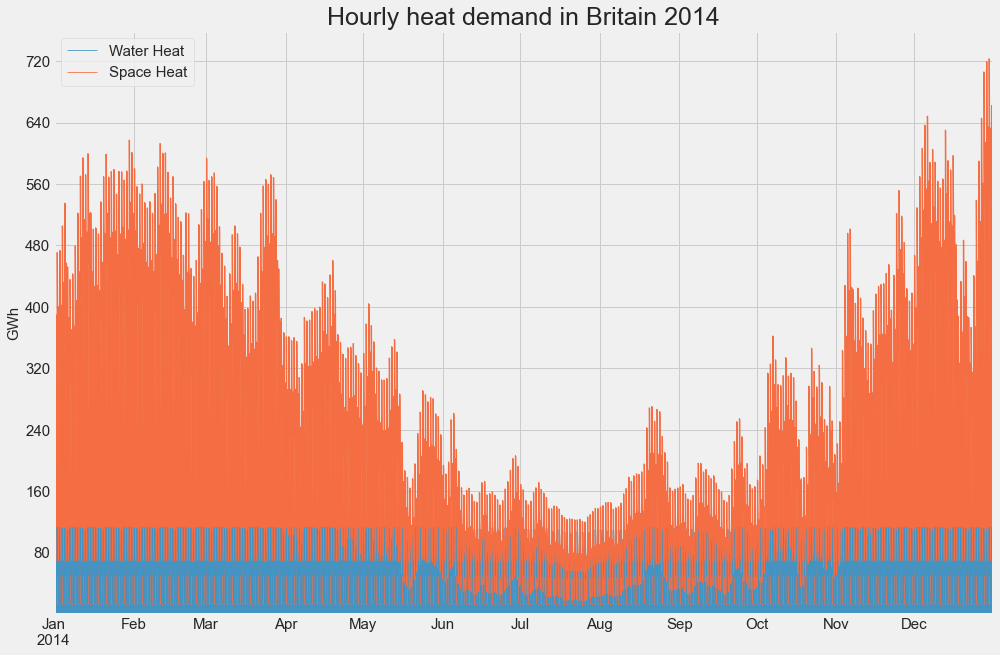

In [31]:
#plot heat demand
from matplotlib.ticker import MaxNLocator
import pyplot_themes as themes


heat_type=gas_profile.sum(level='end-use', axis=1)*0.97
heat_type.index=pd.to_datetime(heat_type.index)

themes.theme_fivethirtyeight()
plot= plt.subplot()
heat_type.plot.area(y=['water_heat', 'space_heat'], stacked=True, color=['#4393c3', '#f46d43'], ax=plot, linewidth=0.8)
plot.set_title('Hourly heat demand in Britain 2014', size=25)
plot.set_ylabel('GWh', size= 15)
plot.legend(labels=['Water Heat', 'Space Heat'], fontsize=15)
plot.tick_params(axis='both', which='major', labelsize=15)
plot.yaxis.set_major_locator(MaxNLocator(prune='both'))
plt.savefig(r'C:\Users\silas\kDrive\Projects\BA\writing\plots\gas_profiles_yearly.png', transparent=True)



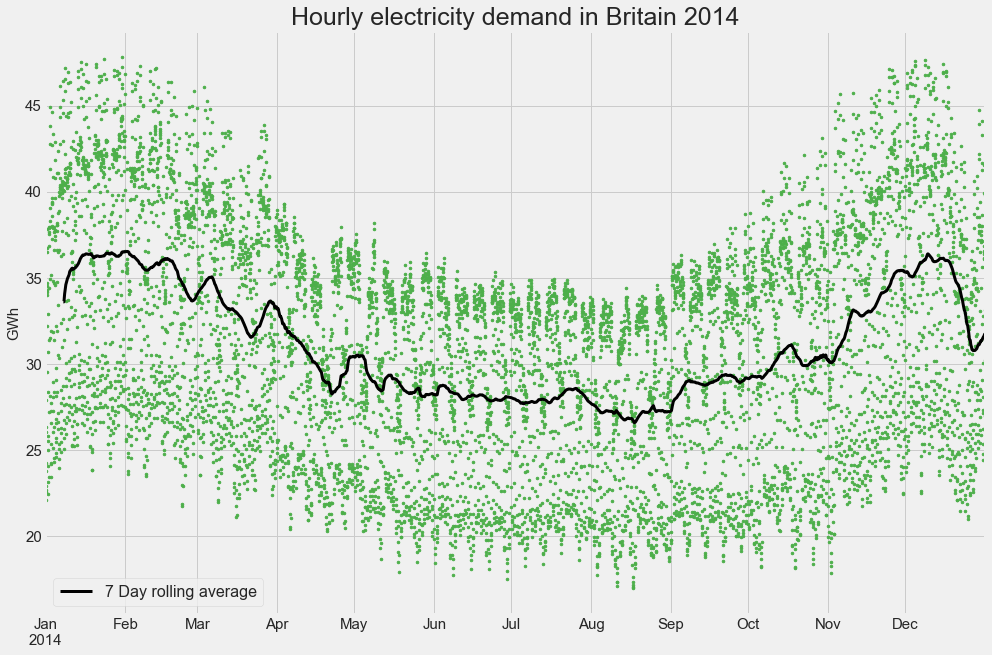

In [30]:
#plot electricity dmenand profile
elec_demand= pd.read_csv(r'electricity_demand_2014.csv', index_col=0, header=0)
elec_demand.index=pd.to_datetime(elec_demand.index)
elec_demand['total']=elec_demand.sum(axis=1)*-1
elec_demand['total_ma'] = elec_demand.total.rolling(168).mean()

ax= plt.subplot()
elec_demand.plot(y='total', legend=False, color='#4daf4a', linewidth=0, marker='o', ms=2.5, ax=ax, label='')
ax.set_title('Hourly electricity demand in Britain 2014', size=25)
ax.set_ylabel('GWh', size=15)
elec_demand.plot(y='total_ma', ax=ax, linewidth=3, color="black", label='7 Day rolling average')
ax.legend(fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('')

plt.savefig(r'C:\Users\silas\kDrive\Projects\BA\writing\plots\elec_plot_yearly.png', transparent=True )


C:\Users\silas\anaconda3\envs\geo\lib\site-packages\plotnine\stats\stat_smooth.py:175: PlotnineWarning: No 'window' specified in the method_args. Using window = 876. The same window is used for all groups or facets
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


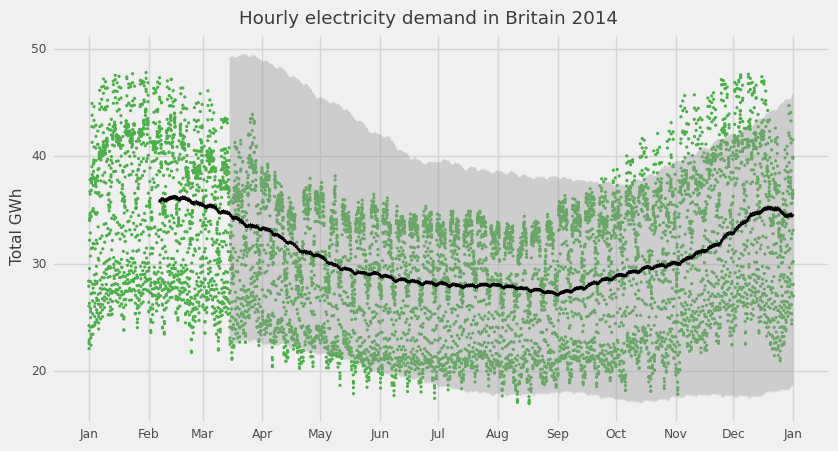

<ggplot: (-9223371942665886532)>

In [17]:
#try with plotnine
import plotnine
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format

(ggplot(aes(y='total', x=elec_demand.index), data=elec_demand)
 +geom_point(size=0.3, color='#4daf4a')#+geom_line(aes(y='total_ma', color='total_ma'), size=1.5, show_legend=True)
 +geom_smooth(method='mavg', show_legend=True )
 +labs(title = "Hourly electricity demand in Britain 2014", y = "Total GWh", size=15)
 +scale_x_datetime(breaks=date_breaks('1 month'),labels=date_format('%b'))
 +theme_538(base_family = "Helvetica"))+theme(figure_size=(10, 5))

#p.save(r'C:\Users\silas\kDrive\Projects\BA\writing\plots\elec_plot_yearly.png', dpi=300)